In [ ]:
# load timestamps for cameras, and demix 

# find relevant peridos that need to be DLC'ed 

# save these out as a csv file and AVi file

In [33]:
import os
import pandas as pd
import numpy as np  
from datetime import datetime
import matplotlib.pyplot as plt
import cv2

def process_camera_data(Camera_ts_raw):

    Camera_ts = convert_uncycle_Timestamps(Camera_ts_raw)

    #check for dropped frames:
    check_timestamps(Camera_ts, Frame_rate = 60)
    # Find triggers:
    Camera_trig_states = find_trigger_states(Camera_ts_raw)
    #check if triggers are working:
    result = np.max(Camera_trig_states) == np.min(Camera_trig_states)
    
    # #pull out video name
    # video_name = [TimeStampPath.split("\\")[-1].split(".")[0] + '-camera-timestamp-data']

    if not result:

        # make camera dataframe:
        Camera_dataframe = pd.DataFrame(
            {'Time Stamps': Camera_ts,
            'Trigger State': Camera_trig_states,
            # 'DataPath': ([TimeStampPath] * len(Camera_ts))
            })
        
    return Camera_dataframe

def converttime(time):
    #offset = time & 0xFFF
    cycle1 = (time >> 12) & 0x1FFF
    cycle2 = (time >> 25) & 0x7F
    seconds = cycle2 + cycle1 / 8000.
    return seconds

def uncycle(time):
    cycles = np.insert(np.diff(time) < 0, 0, False)
    cycleindex = np.cumsum(cycles)
    return time + cycleindex * 128

def convert_uncycle_Timestamps(Camera_ts):
    ##################   Convert the timestamps into seconds and uncycle them:
    t_stamps = {}  
    stamps_s = []
    for indx, row in Camera_ts.iterrows():
        if row.trigger > 0: 
            timestamp_new = converttime(int(row.timestamps))
            stamps_s.append(timestamp_new)
        # else:    
        #     raise ValueError('Timestamps are broken')
    t_stamps = uncycle(stamps_s)
    t_stamps = t_stamps - t_stamps[0] # make first timestamp 0 and the others relative to this 
    return(t_stamps)

def check_timestamps(t_stamps, Frame_rate):
    # plot 1/(diff between time stamps). This tells you roughly the frequency and if you've droppped frames.
    Frame_gaps = 1/np.diff(t_stamps)
    Frames_dropped = 0
    for gaps in Frame_gaps:
        if gaps < (Frame_rate-5) or gaps > (Frame_rate+5):
            Frames_dropped = Frames_dropped + 1
    print('Frames dropped = ' + str(Frames_dropped))

    plt.suptitle('Frame rate = ' + str(Frame_rate) + 'fps', color = 'red')
    frame_gaps = plt.hist(Frame_gaps, bins=100)
    plt.xlabel('Frequency')
    plt.ylabel('Number of frames')
    
def find_trigger_states(Camera_ts_raw):
    triggers = Camera_timestamps.trigger.values[np.where(Camera_timestamps.loc[:,'trigger']>0)]
    down_state = list(triggers)[0]
    down_state_times = np.where(triggers == down_state)
    Triggers_temp = np.ones(len(triggers))
    for index in down_state_times:
        Triggers_temp[index] = 0
    trigger_state = Triggers_temp
    return trigger_state

def load_video(path):
    return cv2.VideoCapture(path)

def get_total_frames(cap):
    return int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

def calculate_interval(total_frames, num_frames):
    return total_frames // num_frames

def process_frame(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    gray_frame = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2GRAY)
    blurred_frame = cv2.GaussianBlur(gray_frame, (15, 15), 0)
    circles = cv2.HoughCircles(blurred_frame, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50, param1=50, param2=30, minRadius=25, maxRadius=40)
    return frame_rgb, circles

def draw_circles(frame_rgb, circles):
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            cv2.circle(frame_rgb, (x, y), r, (0, 255, 0), 4)
            cv2.rectangle(frame_rgb, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
        return len(circles)
    return 0

def analyze_video_type(cam_path, num_frames=20):
    cap = load_video(cam_path)
    total_frames = get_total_frames(cap)
    interval = calculate_interval(total_frames, num_frames)
    
    fig, axes = plt.subplots(2, int(np.ceil(num_frames / 2)), figsize=(15, 6))
    circles_count = []

    for i in range(num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * interval)
        ret, frame = cap.read()
        if ret:
            frame_rgb, circles = process_frame(frame)
            count = draw_circles(frame_rgb, circles)
            circles_count.append(count)
            
            ax = axes[i // int(np.ceil(num_frames / 2)), i % int(np.ceil(num_frames / 2))]
            ax.imshow(frame_rgb)
            ax.set_title(f'Frame {i * interval}')
            ax.axis('off')
        else:
            print(f"Error: Could not read frame at position {i * interval}.")
            circles_count.append(0)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(num_frames), circles_count, marker='o')
    plt.xlabel('Frame Index')
    plt.ylabel('Number of Circles Detected')
    plt.title('Number of Circles Detected in Each Frame')
    plt.show()
    

In [42]:
base_path = r"Z:\projects\sequence_squad\revision_data\lars_recordings\video\\"

for mouse_file in os.listdir(base_path)[3::]:
    mouse_base = os.path.join(base_path, mouse_file)
    for recording in os.listdir(mouse_base):
        full_file = os.path.join(mouse_base, recording)
        for file in os.listdir(full_file):
            if '.csv' in file:
                print(os.path.join(full_file, file))

                Camera_timestamps = pd.read_csv(os.path.join(full_file, file))
                
                if len(Camera_timestamps.columns) > 1:
                    Camera_timestamps.columns = ['trigger', 'timestamps', 'blank']
                    Camera_timestamps.trigger = Camera_timestamps.trigger.astype(float)
                else:
                    Camera_timestamps[['trigger', 'timestamps', 'blank']] = Camera_timestamps.iloc[:, 0].str.split(expand=True)
                    Camera_timestamps.drop(Camera_timestamps.columns[0], axis=1, inplace=True)
                    Camera_timestamps.trigger = Camera_timestamps.trigger.astype(float)
                    
                #check if timestmaps are reversed
                if int(Camera_timestamps.timestamps.astype(float)[1] - Camera_timestamps.timestamps.astype(float)[0]) == 1:
                    Camera_timestamps = Camera_timestamps.rename(columns={'timestamps': 'blank', 'blank': 'timestamps'})
                    
                    # Convert timestamps to datetime
                    Camera_timestamps['datetime'] = pd.to_datetime(Camera_timestamps['timestamps'], unit='ns')
                
                    Camera_dataframe = pd.DataFrame({})
                    Camera_dataframe['Trigger State'] = find_trigger_states(Camera_timestamps)
                    Camera_dataframe['Time Stamps'] = (Camera_timestamps.datetime - Camera_timestamps.datetime[0]).dt.total_seconds()

                else:
                    Camera_dataframe = process_camera_data(Camera_timestamps)
    
## check frames

## find each time period and split the triggers 
# load videos frames7# decided automatically if its above or back...
# split the videos and save new names

## save all out to nice new clean place... 

                    


Z:\projects\sequence_squad\revision_data\lars_recordings\video\\seq006\seq006__20241114\seq006__20241114__timestamp_02024-11-14T09_26_38.csv
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\seq006\seq006__20241114\seq006__20241114__timestamp_22024-11-14T09_26_38.csv
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\seq006\seq006__20241115\seq006__20241115__timestamp_02024-11-15T09_43_02.csv
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\seq006\seq006__20241115\seq006__20241115__timestamp_22024-11-15T09_43_02.csv
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\seq006\seq006__20241116\seq006__20241116__timestamp_02024-11-16T12_19_05.csv
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\seq006\seq006__20241116\seq006__20241116__timestamp_22024-11-16T12_19_05.csv
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\seq006\seq006__20241118\seq006__20241118__timestamp_02024-11-18T13_11_58.csv
Z:\projects\s

In [ ]:
for cam_file in os.listdir(full_file):
    if file.split('.csv')[0] in cam_file:
        if '.avi' in cam_file:
            cam_path = os.path.join(full_file,cam_file)
            
# temp path   
cam_path = r"D:\video_testing\seq006__20241114\seq006__20241114__camera_22024-11-14T09_26_38.avi"
cam_path = r"D:\video_testing\seq006__20241114\seq006__20241114__camera_02024-11-14T09_26_38.avi"

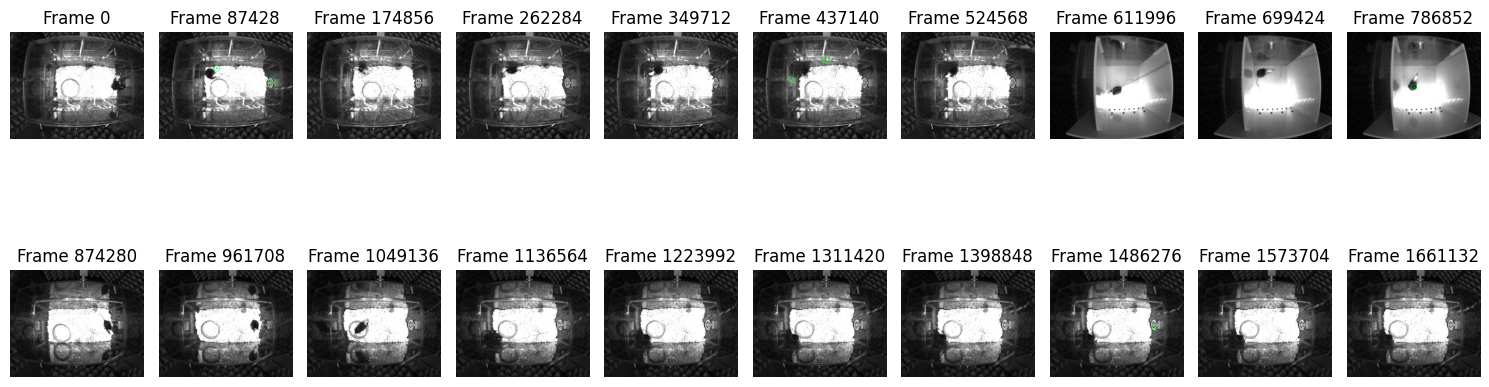

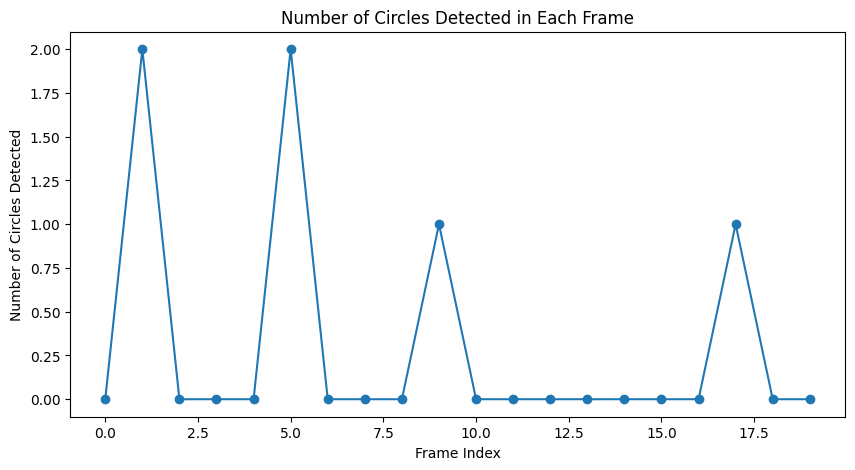

True


In [34]:
cam_path = r"D:\video_testing\seq006__20241114\seq006__20241114__camera_02024-11-14T09_26_38.avi"
# analyze the video based on cicles detected in frames 
analyze_video_type(cam_path)

circles_count
consecutive_threshold = 4
count_threshold = 5
consecutive_count = 0
BACK_CAM = False

for count in circles_count:
    if count > count_threshold:
        consecutive_count += 1
        if consecutive_count >= consecutive_threshold:
            BACK_CAM = True
            break
    else:
        consecutive_count = 0

print(BACK_CAM)


In [45]:
Camera_dataframe

,Trigger State,Time Stamps
0,0.0,0.000000
1,0.0,0.015966
2,0.0,0.031932
3,0.0,0.047898
4,0.0,0.063864
...,...,...
837975,0.0,13379.242926
837976,0.0,13379.258892
837977,0.0,13379.274858
837978,0.0,13379.290824


Frames dropped = 10


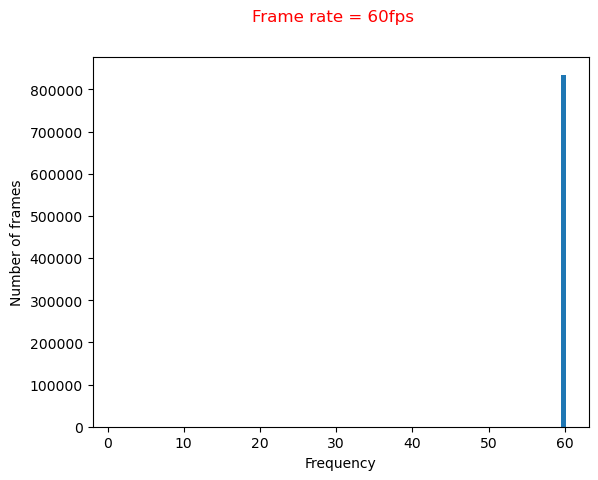

In [17]:
len(Camera_trig_states)

834835

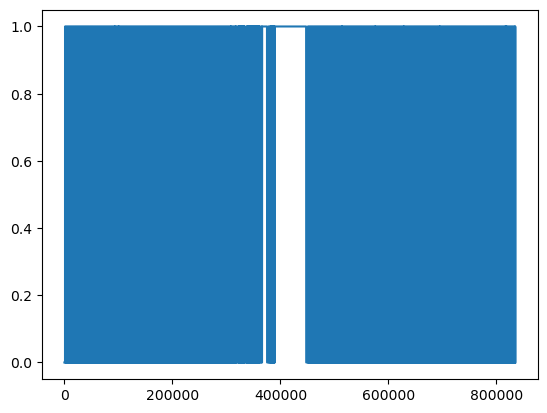

In [14]:
plt.plot(Camera_trig_states)

In [58]:
os.listdir(full_file)

['seq008__20241115__camera_02024-11-15T14_07_23.avi',
 'seq008__20241115__camera_22024-11-15T14_07_23.avi',
 'seq008__20241115__timestamp_02024-11-15T14_07_23.csv',
 'seq008__20241115__timestamp_22024-11-15T14_07_23.csv']

In [67]:
file


'seq008__20241115__timestamp_22024-11-15T14_07_23.csv'

In [68]:
import cv2

for cam_file in os.listdir(full_file):
    if file.split('.csv')[0].split('__')[-1].split('_')[1] in cam_file:
        if '.avi' in cam_file:
            cam_path = os.path.join(full_file,cam_file)

cam_path
# Load the .avi file
cap = cv2.VideoCapture(cam_path)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
else:
    # Read the first frame
    ret, frame = cap.read()
    if ret:
        # Display the first frame
        cv2.imshow('First Frame', frame)
        cv2.waitKey(0)  # Wait for a key press to close the window
        cv2.destroyAllWindows()
    else:
        print("Error: Could not read the first frame.")

# Release the video capture object
cap.release()

KeyboardInterrupt: 

In [ ]:
ret

In [36]:
full_file

'Z:\\projects\\sequence_squad\\revision_data\\lars_recordings\\video\\\\AP5L\\AP5_2_L__20241118'

In [23]:
Camera_timestamps.timestamps.astype(float)

0         7.869948e+08
1         7.875404e+08
2         7.880870e+08
3         7.886326e+08
4         7.891782e+08
              ...     
834830    3.908416e+09
834831    3.908961e+09
834832    3.909507e+09
834833    3.910053e+09
834834    3.910599e+09
Name: timestamps, Length: 834835, dtype: float64

In [ ]:
Camera_timestamps = pd.read_csv(os.path.join(full_file, file))

if len(Camera_timestamps.columns) > 1:
    Camera_timestamps.columns = ['trigger', 'timestamps', 'blank']
    Camera_timestamps.trigger = Camera_timestamps.trigger.astype(float)
else:
    Camera_timestamps[['trigger', 'timestamps', 'blank']] = Camera_timestamps.iloc[:, 0].str.split(expand=True)
    Camera_timestamps.drop(Camera_timestamps.columns[0], axis=1, inplace=True)
    Camera_timestamps.trigger = Camera_timestamps.trigger.astype(float)
    
#check if timestmaps are reversed
if Camera_timestamps.timestamps[1] - Camera_timestamps.timestamps[0] == 1:
    Camera_timestamps = Camera_timestamps.rename(columns={'timestamps': 'blank', 'blank': 'timestamps'})
    
    # Convert timestamps to datetime
    Camera_timestamps['datetime'] = pd.to_datetime(Camera_timestamps['timestamps'], unit='ns')

    Camera_timestamps['timestamps_s'] = (Camera_timestamps.datetime - Camera_timestamps.datetime[0]).dt.total_seconds()
    

In [19]:
Camera_timestamps

,trigger,blank,timestamps,datetime,timestamps_s
0,12.0,22967361,347450753384920,1970-01-05 00:30:50.753384920,0.000000
1,12.0,22967362,347450759343208,1970-01-05 00:30:50.759343208,0.005958
2,12.0,22967363,347450765302400,1970-01-05 00:30:50.765302400,0.011917
3,12.0,22967364,347450771261264,1970-01-05 00:30:50.771261264,0.017876
4,12.0,22967365,347450777220448,1970-01-05 00:30:50.777220448,0.023836
...,...,...,...,...,...
2037999,12.0,25005360,360830060472448,1970-01-05 04:13:50.060472448,13379.307088
2038000,12.0,25005361,360830066715920,1970-01-05 04:13:50.066715920,13379.313331
2038001,12.0,25005362,360830072959048,1970-01-05 04:13:50.072959048,13379.319574
2038002,12.0,25005363,360830079202120,1970-01-05 04:13:50.079202120,13379.325817


In [15]:
if len(Camera_timestamps.columns) > 1:
    Camera_timestamps.columns = ['trigger', 'timestamps', 'blank']
    Camera_timestamps.trigger = Camera_timestamps.trigger.astype(float)
else:
    Camera_timestamps[['trigger', 'timestamps', 'blank']] = Camera_timestamps.iloc[:, 0].str.split(expand=True)
    Camera_timestamps.drop(Camera_timestamps.columns[0], axis=1, inplace=True)
    Camera_timestamps.trigger = Camera_timestamps.trigger.astype(float)


In [16]:
Camera_timestamps

,trigger,timestamps,blank
0,12.0,22967361,347450753384920
1,12.0,22967362,347450759343208
2,12.0,22967363,347450765302400
3,12.0,22967364,347450771261264
4,12.0,22967365,347450777220448
...,...,...,...
2037999,12.0,25005360,360830060472448
2038000,12.0,25005361,360830066715920
2038001,12.0,25005362,360830072959048
2038002,12.0,25005363,360830079202120


In [394]:
Camera_timestamps

,trigger,blank,timestamps
0,12.0,118007421,1461975076160656
1,12.0,118007422,1461975092126600
2,12.0,118007423,1461975108092752
3,12.0,118007424,1461975124058392
4,12.0,118007425,1461975140024672
...,...,...,...
1013466,12.0,119020887,1478156236470696
1013467,12.0,119020888,1478156252436600
1013468,12.0,119020889,1478156268403720
1013469,12.0,119020890,1478156284369696


In [400]:
Camera_timestamps['timestamps']

0          1461975076160656
1          1461975092126600
2          1461975108092752
3          1461975124058392
4          1461975140024672
                 ...       
1013466    1478156236470696
1013467    1478156252436600
1013468    1478156268403720
1013469    1478156284369696
1013470    1478156300335672
Name: timestamps, Length: 1013471, dtype: int64

In [ ]:
1/60
0.015966
Camera_timestamps

0.016666666666666666

In [385]:
np.diff(Camera_timestamps.timestamps)

array([15965944, 15966152, 15965640, ..., 15967120, 15965976, 15965976],
      dtype=int64)

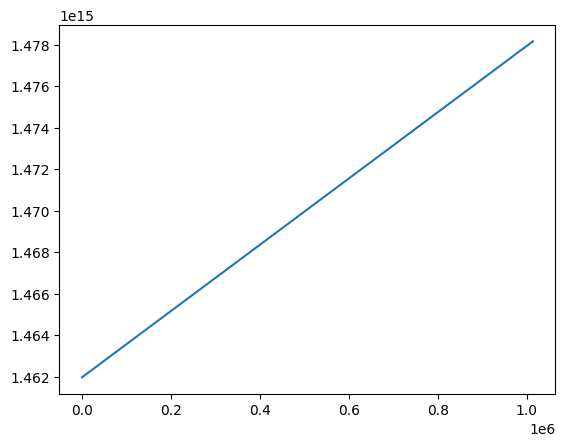

In [389]:
plt.plot(Camera_timestamps.timestamps)

In [ ]:
1478156300335672

1543027.393936197

In [386]:
15965976 * 60

957958560

Frames dropped = 1013470


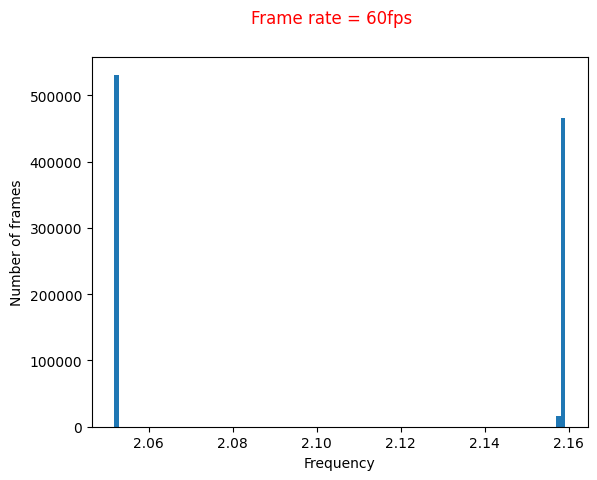

In [369]:
Camera_ts = convert_uncycle_Timestamps(Camera_timestamps)

#check for dropped frames:
check_timestamps(Camera_ts, Frame_rate = 60)

In [371]:
np.diff(Camera_ts)

array([0.46325, 0.48725, 0.48725, ..., 0.48725, 0.46325, 0.48725])

In [373]:
1/0.46325

2.1586616297895307

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_42440\1708563977.py:58: RuntimeWarning: divide by zero encountered in divide
  Frame_gaps = 1/np.diff(t_stamps)


Frames dropped = 1013470


ValueError: supplied range of [7999.999999990223, inf] is not finite

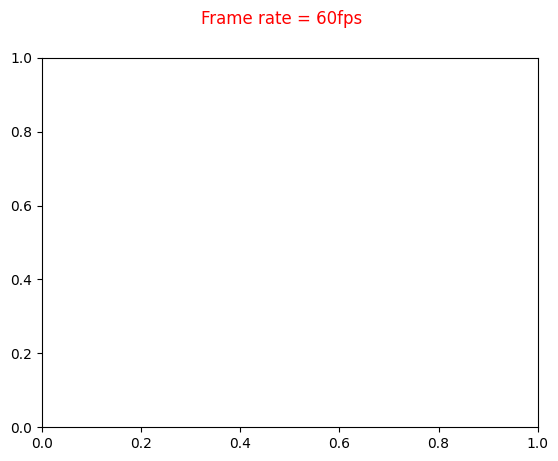

In [341]:
check_timestamps(Camera_ts, Frame_rate = 60)

Frames dropped = 1013470


Text(0, 0.5, 'Number of frames')

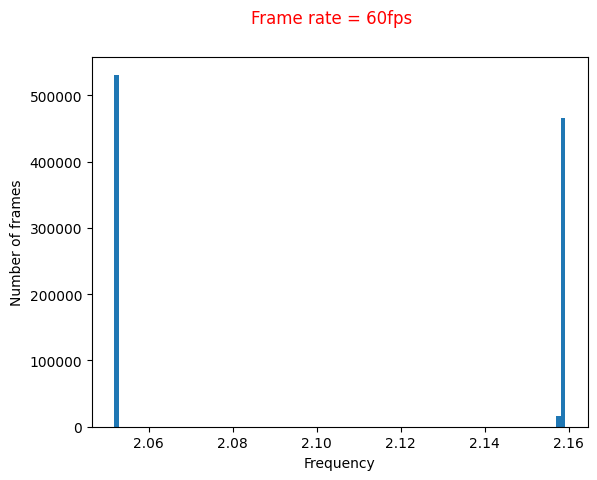

In [372]:
# plot 1/(diff between time stamps). This tells you roughly the frequency and if you've droppped frames.
Frame_rate = 60
Frame_gaps = 1/np.diff(Camera_ts)
Frames_dropped = 0
for gaps in Frame_gaps:
    if gaps < (Frame_rate-5) or gaps > (Frame_rate+5):
        Frames_dropped = Frames_dropped + 1
print('Frames dropped = ' + str(Frames_dropped))

plt.suptitle('Frame rate = ' + str(Frame_rate) + 'fps', color = 'red')
frame_gaps = plt.hist(Frame_gaps, bins=100)
plt.xlabel('Frequency')
plt.ylabel('Number of frames')

In [345]:
Camera_ts

array([0.      , 0.      , 0.      , ..., 0.030875, 0.030875, 0.030875])

In [343]:
Camera_ts

array([0.      , 0.      , 0.      , ..., 0.030875, 0.030875, 0.030875])

In [321]:
# def uncycle(time):
#     cycles = np.insert(np.diff(time) < 0, 0, False)
#     cycleindex = np.cumsum(cycles)
#     return time + cycleindex * 128

    ##################   Convert the timestamps into seconds and uncycle them:
t_stamps = {}  
stamps_s = []
for indx, row in Camera_timestamps.iterrows():
    if row.trigger > 0: 
        timestamp_new = converttime(int(row.timestamps))
        stamps_s.append(timestamp_new)
    # else:    
    #     break
    #     raise ValueError('Timestamps are broken')
t_stamps = uncycle(stamps_s)
t_stamps = t_stamps - t_stamps[0] # make first timestamp 0 and the others relative to this 


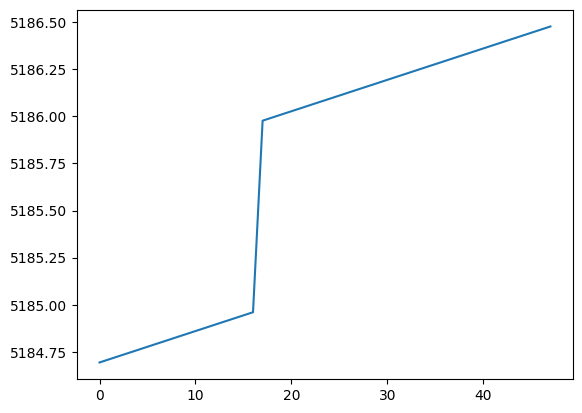

In [324]:
plt.plot(t_stamps[311170:311218])

In [325]:
os.path.join(full_file, file)

'Z:\\projects\\sequence_squad\\revision_data\\lars_recordings\\video\\\\AP5R\\AP5_2_R__20241116\\camera1_2024-11-16T12_24_50.csv'

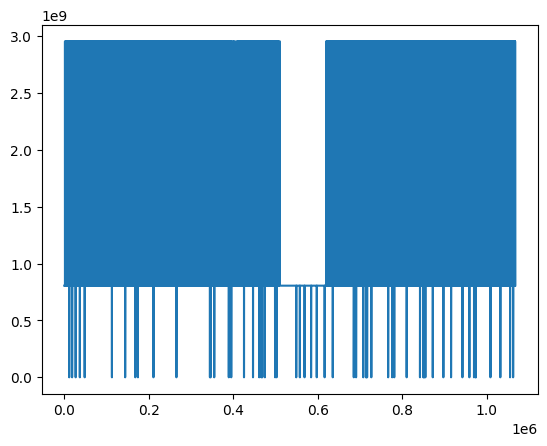

In [33]:
#above cam my setup 
path = r"Z:\projects\sequence_squad\revision_data\lars_recordings\video\AP5L\AP5_2_L__20241118\camera1_2024-11-18T14_00_31.csv"
#back cam my setup 
path = r"Z:\projects\sequence_squad\revision_data\lars_recordings\video\AP5L\AP5_2_L__20241118\camera2_2024-11-18T14_00_31.csv"

# above cam sthita setup:
path = r"Z:\projects\sequence_squad\revision_data\lars_recordings\video\seq006\seq006__20241114\seq006__20241114__timestamp_02024-11-14T09_26_38.csv"

# back cam sthita setup:
path = r"Z:\projects\sequence_squad\revision_data\lars_recordings\video\AP5R\AP5_2_R__20241120\camera1_2024-11-20T09_00_51.csv"

Camera_timestamps = pd.read_csv(path)

if len(Camera_timestamps.columns) > 1:
    Camera_timestamps.columns = ['trigger', 'timestamps', 'blank']
    Camera_timestamps.trigger = Camera_timestamps.trigger.astype(float)
else:
    Camera_timestamps[['trigger', 'timestamps', 'blank']] = Camera_timestamps.iloc[:, 0].str.split(expand=True)
    Camera_timestamps.drop(Camera_timestamps.columns[0], axis=1, inplace=True)
    Camera_timestamps.trigger = Camera_timestamps.trigger.astype(float)


plt.plot(Camera_timestamps.trigger)

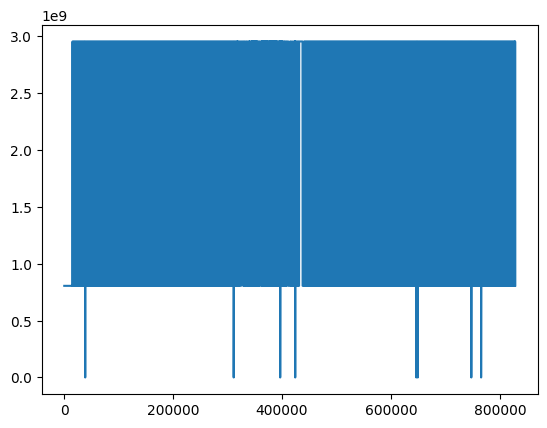

In [320]:
plt.plot(Camera_timestamps.trigger)

In [315]:
Camera_timestamps[311180:311198]

,trigger,timestamps,blank
311180,805306368.0,65188907,16427718
311181,805306368.0,65734499,16427719
311182,805306368.0,66280099,16427720
311183,805306368.0,67613154,16427721
311184,805306368.0,68158746,16427722
311185,805306368.0,68704344,16427723
311186,805306368.0,69249944,16427724
311187,805306368.0,69796561,16427725
311188,0.0,0,0
311189,805306368.0,103880773,16427786


[1.9653749999999999, 1.982, 1.998625, 2.015375, 2.032, 2.048625, 2.06525, 2.082, 0.0, 3.098125, 3.11475, 3.1315, 3.148125, 3.16475, 3.1814999999999998, 3.198125, 3.21475, 3.231375]


1.0161250000000002

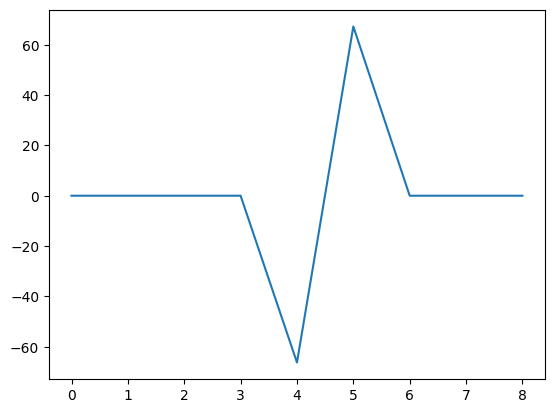

In [317]:

print(list((converttime(int(item))) for item in Camera_timestamps.timestamps[311180:311198]))

plt.plot(np.diff(list((converttime(int(item))) for item in Camera_timestamps.timestamps[38480:38490])).astype(float))

3.098125 - 2.082

In [304]:
Camera_timestamps.to_timestamp[38480:38490]

TypeError: 'method' object is not subscriptable

In [292]:
converttime(2256296592)

67.248625

In [285]:
16155024 - 16154963

61

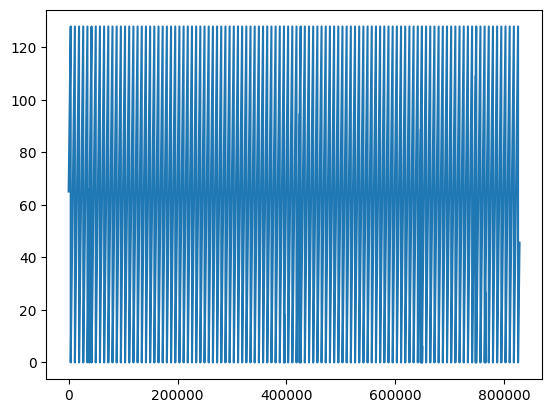

In [278]:
plt.plot(stamps_s)

In [290]:
(t_stamps[-1]/60)/60

4.119036562500001

In [291]:
t_stamps[-1]

14828.531625000001

In [272]:
0.8345921180555558 * 60

50.07552708333335

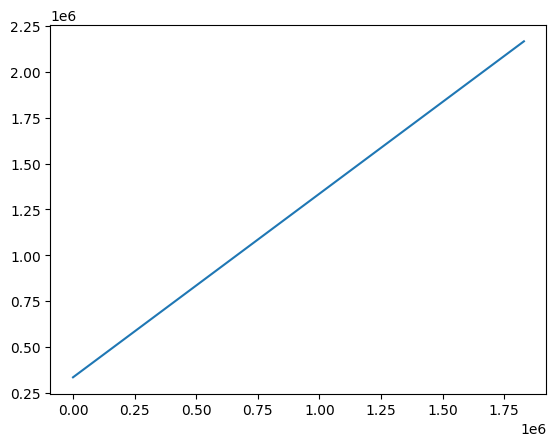

In [146]:
plt.plot(Camera_timestamps.timestamps)


In [130]:


# Efficiently load the data
Camera_timestamps = pd.read_csv(
    r"Z:\projects\sequence_squad\revision_data\lars_recordings\video\seq008\seq008__20241111\timestamp_02024-11-11T15_02_12.csv",
    sep=' ',  # Space-separated values
    header=None,  # No headers in the file
    names=['triggers', 'timestamps1', 'timestamps2'],  # Column names
    usecols=[0, 1, 2]  # Only load the three columns
)

# View the result
print(Camera_timestamps.head())

ParserError: Too many columns specified: expected 3 and found 1

In [ ]:
# Efficiently load the data
Camera_timestamps = pd.read_csv(
    os.path.join(full_file, file),
    sep=' ',  # Space-separated values
    header=None,  # No headers in the file
    names=['triggers', 'timestamps1', 'timestamps2'],  # Column names
    usecols=[0, 1, 2]  # Only load the three columns
)

# View the result
print(Camera_timestamps.head())

    triggers  timestamps1  timestamps2
0  805306368    786449218     26832687
1  805306368    786994810     26832688
2  805306368    787540410     26832689
3  805306368    788087033     26832690
4  805306368    788632625     26832691


In [118]:
##################   Convert the timestamps into seconds and uncycle them:
t_stamps = {}  
stamps_s = []
for indx, row in Camera_timestamps.iterrows():
    # if row.triggers > 0: 
    timestamp_new = converttime(Camera_timestamps.at[indx,'timestamps1'])
    stamps_s.append(timestamp_new)
    # else:    
        # raise ValueError('Timestamps are broken')
t_stamps = uncycle(stamps_s)
t_stamps = t_stamps - t_stamps[0] # make first timestamp 0 and the others relative to this 

In [114]:
Camera_timestamps.timestamps2.values[-1] - Camera_timestamps.timestamps2.values[0]

835425

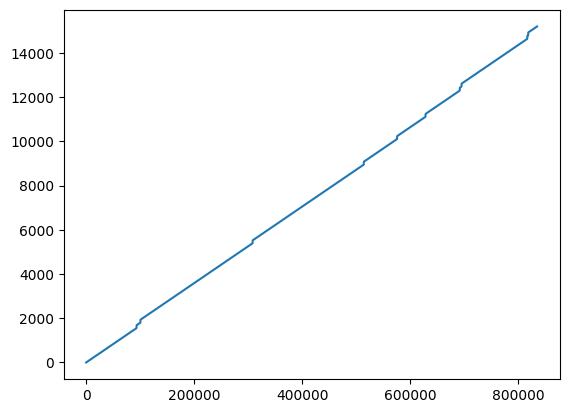

In [119]:
plt.plot(t_stamps)

In [121]:
t_stamps[-1] - t_stamps[0]

15197.1095

In [124]:
t_stamps[-1]/(1/60)

911826.5700000001

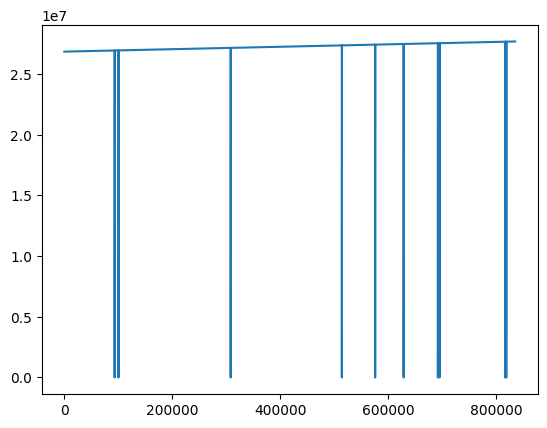

In [116]:
plt.plot(Camera_timestamps.timestamps2)

In [115]:
Camera_timestamps

,triggers,timestamps1,timestamps2
0,805306368,786449218,26832687
1,805306368,786994810,26832688
2,805306368,787540410,26832689
3,805306368,788087033,26832690
4,805306368,788632625,26832691
...,...,...,...
834831,805306368,3908415963,27668108
834832,805306368,3908961435,27668109
834833,805306368,3909507148,27668110
834834,805306368,3910052754,27668111


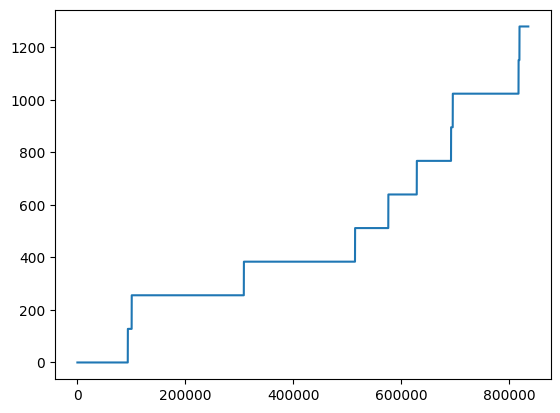

In [107]:

# plt.plot(Camera_timestamps.triggers)
plt.plot(t_stamps)
# plt.ylim(1500,1700)
# plt.xlim(90000,102000)

In [101]:
len(t_stamps)

834836

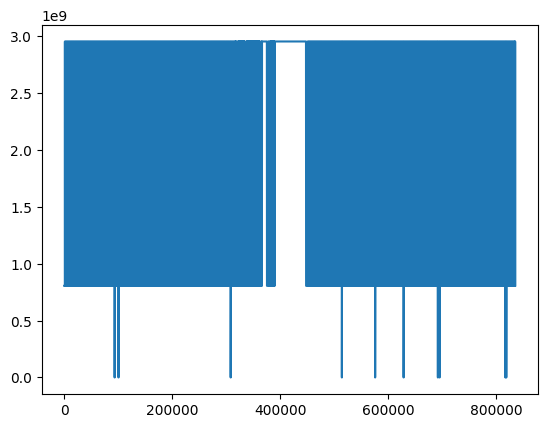

In [79]:
import matplotlib.pyplot as plt
plt.plot(Camera_timestamps.triggers)

In [80]:
Camera_timestamps.triggers.unique()

array([ 805306368, 2952790016,          0], dtype=int64)

In [76]:
row

triggers       805306368
timestamps1    786449218
timestamps2     26832687
Name: 0, dtype: int64

In [75]:
for indx, row in Camera_timestamps.iterrows():
    row
    break

In [45]:
'Trigger', 'Timestamp', 'blank'

('Trigger', 'Timestamp', 'blank')

In [49]:
Camera_timestamps.columns

Index(['805306368 786449218 26832687 '], dtype='object')

In [44]:
Camera_timestamps.columns = ['1', '2', '3']
Camera_timestamps

ValueError: Length mismatch: Expected axis has 1 elements, new values have 3 elements

In [36]:
Camera_timestamps

,805306368 786449218 26832687
0,805306368 786994810 26832688
1,805306368 787540410 26832689
2,805306368 788087033 26832690
3,805306368 788632625 26832691
4,805306368 789178217 26832692
...,...
834830,805306368 3908415963 27668108
834831,805306368 3908961435 27668109
834832,805306368 3909507148 27668110
834833,805306368 3910052754 27668111


In [ ]:
process_camera_data(stamps) 




,Item1,Item2,Item3
0,12,22967361,347450753384920
1,12,22967362,347450759343208
2,12,22967363,347450765302400
3,12,22967364,347450771261264
4,12,22967365,347450777220448
...,...,...,...
2037999,12,25005360,360830060472448
2038000,12,25005361,360830066715920
2038001,12,25005362,360830072959048
2038002,12,25005363,360830079202120


In [ ]:
## uncycle the stamps

find the TTL trigs

## load some camera frames and try to decide automatically if it is the above or back cam 

seq008__20241115__timestamp_02024-11-15T14_07_23.csv
seq008__20241115__timestamp_22024-11-15T14_07_23.csv
